In [192]:
import numpy as np
import pandas as pd

from globalbonds.dataio.data_lib import DataLib
from globalbonds.indicators.data_utils import *
from globalbonds.indicators.signal import Signal
from globalbonds.indicators.indicator import Indicator
from globalbonds.indicators.assess_signal import predictive_accuracy
from globalbonds.indicators.return_utils import *
from globalbonds.indicators.normalization import *


from plotnine import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

COUNTRIES = ['USA', 'JPN', 'AUS', 'DEU']
COUNTRIES = ['JPN', 'CAN', 'ESP', 'DEU', 'ITA', 'GBR', 'NOR', 'AUS', 'USA', 'SWE']
dlib = DataLib('../SignalData')


def mask(tbl):
    tbl = tbl[COUNTRIES]
    tbl = tbl.loc['1980-01-01':'2010-01-01']
    return tbl

bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('M').mean()

cash_rate = dlib.pull('RiskFree-Rate')['USA']  # Pull Ticker USGBILL3
cash_rate = cash_rate / 100  # convert cash rate into fraction
cash_rate = cash_rate.map(lambda r: (1 + r) ** (1 / 12) - 1)  # convert annualized cash rate to quarterly
cash_rate = cash_rate.resample('M').apply(lambda x: x[0])  # get rate at start of each month  

def calc_signal_returns(bond_returns, signal):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    bond_returns = bond_returns.fillna(0)
    bond_returns += 1

    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) + 1
    signal_returns /= (1 + cash_rate)
    signal_returns = signal_returns.cumprod()
    return signal_returns


dlib.list()

['GDP-Real',
 'EquityPrices',
 'LongRates',
 'CurrAcctNom-inUSD',
 'CoreCPI-SA',
 'fxTrdWts-Real',
 'M3-inUSD',
 'RiskFree-Rate',
 'CurrAcctPctGDP',
 'fxTrdWts-Nominal',
 'BondRetIdx-LocalFX',
 'fxVsUSD',
 'M2-inUSD',
 'M1-inUSD',
 'ShortRates',
 'GDP-Nominal']

In [185]:
dlib.pull('BondRetIdx-LocalFX')

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,NOR,SWE,CHE,GBR,USA
date,,,,,,,,,,,,
1980-01-01,NaN,49.321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.143,37.527
1980-01-02,NaN,49.330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.882,37.156
1980-01-03,NaN,49.163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.911,36.941
1980-01-04,NaN,49.116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.123,36.859
1980-01-07,NaN,49.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.268,36.926
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-28,1552.723,681.427,974.301,1356.134,891.165,1260.245,326.283,655.674,1180.108,402.646,1071.062,735.002
2020-07-29,1560.318,680.876,973.545,1357.307,890.201,1262.268,326.350,655.993,1179.792,401.559,1069.524,735.014
2020-07-30,1561.474,683.691,976.188,1361.476,892.925,1265.716,326.318,657.649,1182.539,402.988,1072.101,737.767


In [186]:
m2 = mask(dlib.pull('M2-inUSD')).iloc[6:]
m2_3m = m2.rolling(3).mean()
m2_12m = m2.rolling(12).mean()
m2_delta = m2_3m / m2_12m
m2 = Signal('M2 Delta', m2_delta)

m2_sig = signalize(m2.data.resample('M').mean())
m2_returns = calc_signal_returns(bond_returns, m2_sig)
print(m2_sig.shape)
m2_returns

/home/dcdanko/Dev/Internship2020/globalbonds/globalbonds/indicators/normalization.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: x[:window - gap].mean()
/home/dcdanko/Dev/Internship2020/globalbonds/globalbonds/indicators/normalization.py:29: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: x[:window - gap].mean()


(355, 4)


date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2009-09    0.292661
2009-10    0.290770
2009-11    0.291649
2009-12    0.296997
2010-01    0.300465
Freq: M, Length: 361, dtype: float64

In [187]:
cpi = mask(dlib.pull('CoreCPI-SA')).iloc[3:]
cpi = derivative(cpi, s=3)
cpi = - cpi
cpi = Signal('CPI', cpi)

cpi_sig = signalize(cpi.data.resample('M').mean())
cpi_returns = calc_signal_returns(bond_returns, cpi_sig)
print(cpi_sig.shape)
cpi_returns

(355, 4)


date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2009-09    0.169188
2009-10    0.170656
2009-11    0.170175
2009-12    0.168866
2010-01    0.168256
Freq: M, Length: 361, dtype: float64

In [188]:
fx = mask(dlib.pull('fxVsUSD'))
fx['USA'] = 1 / fx.drop(columns='USA').mean(axis=1)
W = 2
fx = fx.rolling(W).apply(lambda x: x[W - 1] / x[:W - 1].mean())
fx = derivative(fx, s=6)
fx = fx.applymap(lambda x: 1 / x)
fx = Signal('FX', fx, normalizer=lambda x: x)

fx_sig = signalize(fx.data.resample('M').mean())
fx_returns = calc_signal_returns(bond_returns, fx_sig)
print(fx_sig.shape)
fx_returns

(355, 4)


/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.


date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2009-09    0.322507
2009-10    0.320493
2009-11    0.319924
2009-12    0.327940
2010-01    0.329648
Freq: M, Length: 361, dtype: float64

In [189]:
comb_sig = signalize(-1 * fx_sig + 1 * cpi_sig + 1 * m2_sig)

#pairwise_extreme_signal(comb_sig, m2_sig)
calc_signal_returns(bond_returns, comb_sig)

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2009-09    0.180698
2009-10    0.181406
2009-11    0.181212
2009-12    0.180102
2010-01    0.181081
Freq: M, Length: 361, dtype: float64

In [190]:
comb_sig = signalize(-1 * fx_sig + 1 * cpi_sig + 1 * m2_sig)

comb_sig, comb_returns = pairwise_extreme_signal(comb_sig, fx_sig)
#comb_sig, comb_returns = pairwise_extreme_signal(comb_sig, cpi_sig)
comb_returns

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2009-09    0.183498
2009-10    0.184217
2009-11    0.183890
2009-12    0.188497
2010-01    0.189521
Freq: M, Length: 361, dtype: float64

In [176]:
sigs = pd.DataFrame({
    'fx': fx_sig.apply(extremity, axis=1),
    'cpi': cpi_sig.apply(extremity, axis=1),
    'm2': m2_sig.apply(extremity, axis=1),
})
sigs * sigs



,fx,cpi,m2
date,,,
1980-07,NaN,NaN,NaN
1980-08,0.573254,NaN,NaN
1980-09,0.630549,NaN,NaN
1980-10,0.799294,NaN,NaN
1980-11,0.829870,NaN,NaN
...,...,...,...
2020-04,0.803463,0.899951,0.618024
2020-05,0.593541,0.900941,0.886447
2020-06,0.395050,0.708190,0.544947


In [177]:
sig_sq = sigs * sigs
weights = (sig_sq.T / sig_sq.fillna(0).sum(axis=1)).T
weights


,fx,cpi,m2
date,,,
1980-07,NaN,NaN,NaN
1980-08,1.000000,NaN,NaN
1980-09,1.000000,NaN,NaN
1980-10,1.000000,NaN,NaN
1980-11,1.000000,NaN,NaN
...,...,...,...
2020-04,0.346106,0.387670,0.266225
2020-05,0.249290,0.378399,0.372312
2020-06,0.239688,0.429678,0.330634


In [181]:


comb_sig = signalize((-1 * weights['fx'] * fx_sig.T).T + (1.1 * weights['cpi'] * cpi_sig.T).T + (1 * weights['m2'] * m2_sig.T).T)

calc_signal_returns(bond_returns, comb_sig)

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.335128
2020-05    0.326789
2020-06    0.329268
2020-07    0.329243
2020-08    0.329213
Freq: M, Length: 488, dtype: float64

In [195]:
mom_sig = get_momentum_signal(bond_returns, window=12).iloc[6:]
mom_returns = calc_signal_returns(bond_returns, mom_sig)
print(mom_sig.shape)
mom_returns

(355, 10)


/home/dcdanko/Dev/Internship2020/globalbonds/globalbonds/indicators/return_utils.py:21: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  momentum_signal = momentum_signal.rolling(window).apply(lambda x: x[:window - 1].mean())


date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2009-09    0.804941
2009-10    0.820449
2009-11    0.815608
2009-12    0.827592
2010-01    0.838046
Freq: M, Length: 361, dtype: float64

In [131]:
sigs = pd.DataFrame({
    'fx': fx_sig.apply(extremity, axis=1),
    'cpi': cpi_sig.apply(extremity, axis=1),
    'm2': m2_sig.apply(extremity, axis=1),
})

extremes = sigs.idxmax(axis=1).loc[fx_sig.index]
ext_sig = fx_sig.copy()
ext_sig.loc[extremes == 'm2'] = m2_sig.loc[fx_sig.index][extremes == 'm2']
ext_sig.loc[extremes == 'cpi'] = cpi_sig.loc[fx_sig.index][extremes == 'cpi']

ext_returns = calc_signal_returns(bond_returns, ext_sig)
ext_returns

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.388729
2020-05    0.377642
2020-06    0.386443
2020-07    0.384057
2020-08    0.384022
Freq: M, Length: 488, dtype: float64

In [132]:

def pairwise_extreme_signal(sig1, sig2, rev=False):
    pick2 = sig2.apply(extremity, axis=1) > sig1.apply(extremity, axis=1)
    if rev:
        pick2 = ~pick2
    ext_sig = sig1.copy()
    ext_sig[pick2] = sig2[pick2]

    ext_returns = calc_signal_returns(bond_returns, ext_sig)
    return ext_sig, ext_returns


fx_m2_sig, fx_m2_returns = pairwise_extreme_signal(fx_sig, m2_sig, rev=True)
fx_m2_returns

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.396828
2020-05    0.392152
2020-06    0.388747
2020-07    0.388718
2020-08    0.388682
Freq: M, Length: 488, dtype: float64

In [133]:
fx_cpi_sig, fx_cpi_returns = pairwise_extreme_signal(fx_sig, cpi_sig)
fx_cpi_returns

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.383677
2020-05    0.372734
2020-06    0.381421
2020-07    0.379066
2020-08    0.379031
Freq: M, Length: 488, dtype: float64

In [134]:
m2_cpi_sig, m2_cpi_returns = pairwise_extreme_signal(m2_sig, cpi_sig, rev=False)
m2_cpi_returns

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.272446
2020-05    0.264676
2020-06    0.270844
2020-07    0.270824
2020-08    0.270799
Freq: M, Length: 488, dtype: float64

In [135]:
mom_returns

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    1.478258
2020-05    1.470190
2020-06    1.450252
2020-07    1.452666
2020-08    1.465979
Freq: M, Length: 488, dtype: float64

In [136]:
pairwise_extreme_signal(fx_sig, mom_sig, rev=False)[1]

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.945262
2020-05    0.940103
2020-06    0.927354
2020-07    0.928898
2020-08    0.928813
Freq: M, Length: 488, dtype: float64

In [137]:
pairwise_extreme_signal(m2_sig, mom_sig, rev=True)[1]

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.931494
2020-05    0.926410
2020-06    0.914047
2020-07    0.915568
2020-08    0.923958
Freq: M, Length: 488, dtype: float64

In [138]:

for sig in [fx_sig, m2_sig, cpi_sig, fx_cpi_sig, m2_cpi_sig, fx_m2_sig]:
    for a in [True, False]:
        print(pairwise_extreme_signal(sig, mom_sig, rev=a)[1])

date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.552320
2020-05    0.545812
2020-06    0.541072
2020-07    0.537731
2020-08    0.542659
Freq: M, Length: 488, dtype: float64
date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.945262
2020-05    0.940103
2020-06    0.927354
2020-07    0.928898
2020-08    0.928813
Freq: M, Length: 488, dtype: float64
date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.931494
2020-05    0.926410
2020-06    0.914047
2020-07    0.915568
2020-08    0.923958
Freq: M, Length: 488, dtype: float64
date
1980-01    0.990659
1980-02    0.979451
1980-03    0.968567
1980-04    0.960412
1980-05    0.954316
             ...   
2020-04    0.419227
2020-05    0.415484
2020-06    0.409849
2020-07    0.409818
2020-08  

/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 127 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)
/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 763 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


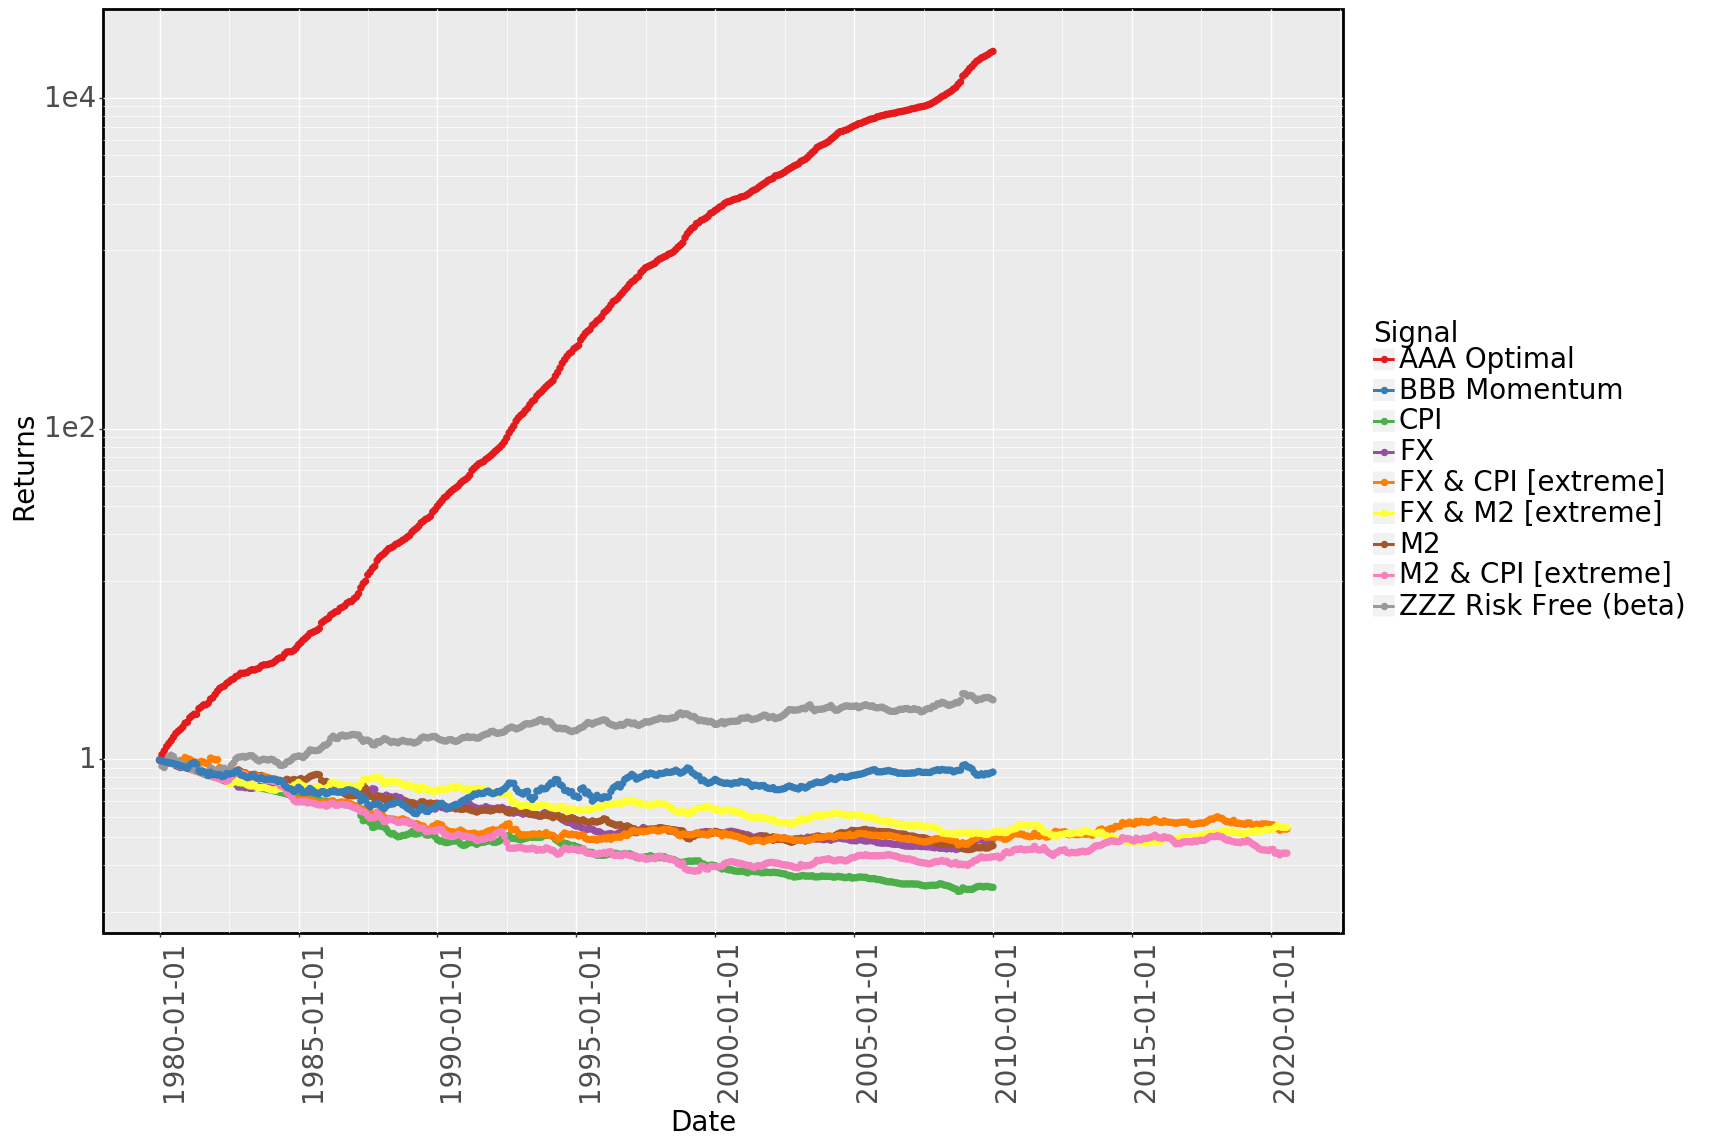

<ggplot: (8739433829433)>

In [194]:

def get_risk_free_return(bond_returns):
    risk_free_returns = bond_returns['USA'].pct_change() + 1
    risk_free_returns /= (1 + cash_rate)
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns


df = {
    'FX': fx_returns,
    'CPI': cpi_returns,
    'M2': m2_returns,
    
    'FX & CPI [extreme]': fx_cpi_returns,
    'FX & M2 [extreme]': fx_m2_returns,
    'M2 & CPI [extreme]': m2_cpi_returns,
    
    'AAA Optimal': calc_signal_returns(bond_returns, get_optimal_signal(bond_returns)),
    'ZZZ Risk Free (beta)': get_risk_free_return(bond_returns),
    
    'BBB Momentum': mom_returns,
}
# for i in range(5):
#     df[f'random {i}'] = calc_signal_returns(bond_returns, get_random_signal(bond_returns))
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
df['color'] = df['variable'].map(lambda x: x.split()[0] if 'random' in x else x)
(
    ggplot(df, aes(x='date', y='value', color='color')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [121]:
foo = (bond_returns['USA'].pct_change() + 1) / (1 + cash_rate)
foo

date
1980-01         NaN
1980-02    0.891270
1980-03    0.957208
1980-04    1.052070
1980-05    1.069053
             ...   
2020-04    1.030300
2020-05    0.996409
2020-06    0.996135
2020-07    1.011686
2020-08    1.008337
Freq: M, Name: USA, Length: 488, dtype: float64

In [122]:
foo.cumprod()

date
1980-01         NaN
1980-02    0.891270
1980-03    0.853131
1980-04    0.897553
1980-05    0.959532
             ...   
2020-04    0.141696
2020-05    0.141187
2020-06    0.140641
2020-07    0.142285
2020-08    0.143471
Freq: M, Name: USA, Length: 488, dtype: float64

In [21]:
class InflationIndicator:
    
    def __init__(self, fx, cpi, m2):
        self.streams = {
            'fx': fx,
            'cpi': cpi,
            'm2': m2,
        }
        
    @property
    def signals(self):
        return {k: signalize(v).fillna(0) for k, v in self.streams.items()}
    
        
ii = InflationIndicator(fx.data.resample('M').mean(), cpi.data.resample('M').mean(), m2.data.resample('M').mean())

In [23]:
from scipy.stats import pearsonr, spearmanr

def cor(X, Y):
    X = X.loc[Y.index].dropna()
    Y = Y.loc[X.index]
    out = {}
    for var in set(X.columns) & set(Y.columns):
        out[var] = pearsonr(X[var], Y[var])[0]
    return out

cor(ii.signals['fx'], ii.signals['cpi'])

{'NOR': -0.010360791901162698,
 'AUS': 0.06187761915048152,
 'CAN': -0.04716536494704393,
 'GBR': 0.013471829489351975,
 'ESP': -0.030524589045661542,
 'JPN': 0.017335619600877122,
 'USA': 0.03175881012861688,
 'SWE': -0.043567883322064856,
 'ITA': -0.05596797262699391,
 'DEU': 0.01437474592551874}

In [24]:
cor(ii.signals['m2'], ii.signals['cpi'])

{'NOR': 0.15331605759246708,
 'AUS': -0.134989110919333,
 'CAN': 0.028603105614015464,
 'GBR': 0.08902522338663009,
 'ESP': -0.053446931654241706,
 'JPN': 0.05402284762470076,
 'USA': -0.21110159639552833,
 'SWE': -0.12364257507637384,
 'ITA': 0.011436996002204646,
 'DEU': 0.18192476344597053}

In [25]:
cor(ii.signals['fx'], ii.signals['m2'])

{'NOR': 0.028662543614690582,
 'AUS': -0.04945394055469035,
 'CAN': -0.04257913237062169,
 'GBR': -0.008975458167432648,
 'ESP': -0.03706943283326834,
 'JPN': -0.054704118682282796,
 'USA': -0.016529463145326277,
 'SWE': 0.04051302817303618,
 'ITA': -0.06656495700099724,
 'DEU': 0.024313763854489724}